While preparing the first in an upcoming series of posts on [multi-armed bandits](https://en.wikipedia.org/wiki/Multi-armed_bandit), I realized that a post diving deep on a simple Monte Carlo estimate of $\pi$ would be a useful companion, so here it is.

## Monte Carlo Methods: the Standard Introductory Example

[Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method) are a powerful tool for approximating hard- or impossible-to-calculate quantities using randomness and simulation.  In my [talks](https://austinrochford.com/talks.html) on Bayesian computation with [PyMC](https://www.pymc.io/welcome.html), I like to follow convention by introducing Monte Carlo methods by approximating $\pi$ as follows.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
from matplotlib import pyplot as plt, ticker
import numpy as np
from scipy.stats import norm
import seaborn as sns

In [3]:
sns.set(color_codes=True)

We begin by generating 5,000 uniformly random points in the unit square $0 \leq x, y \leq 1$.

In [4]:
# for reproducibility
SEED = 123456789

rng = np.random.default_rng(SEED)

In [5]:
N = 5_000

In [6]:
x, y = rng.uniform(size=(2, N))

Here we visualize these samples.

In [7]:
def make_axes():
    _, ax = plt.subplots()
    ax.set_aspect("equal")

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xlim(0, 1.01)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_ylim(0, 1.01)

    return ax

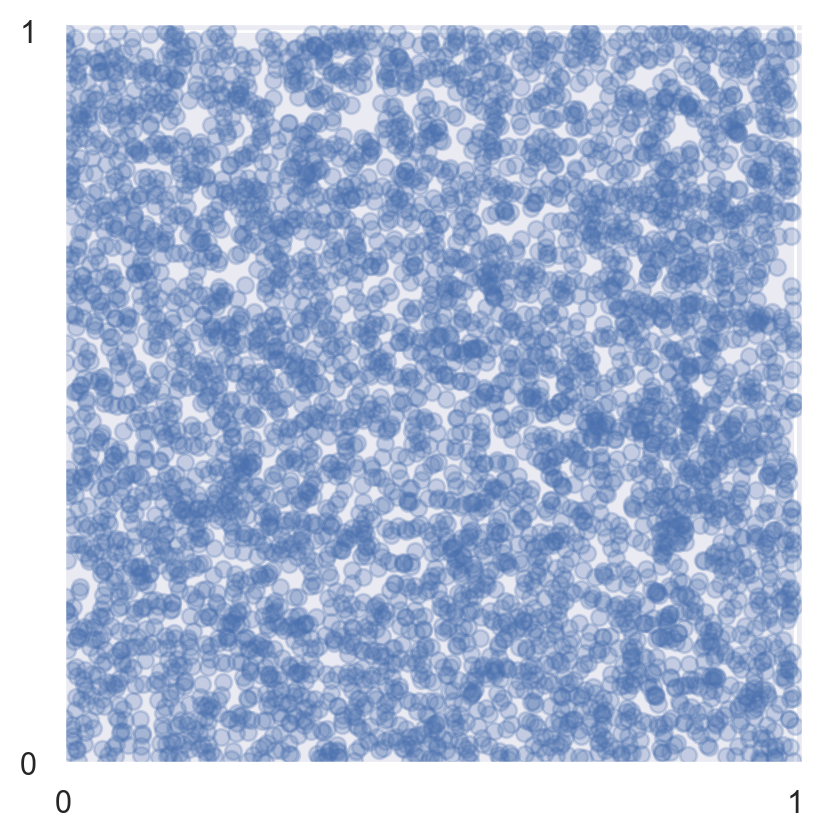

In [8]:
ax = make_axes()
ax.scatter(x, y, alpha=0.25);

Next we overlay the quarter of the unit circle corresponding to $y = \sqrt{1 - x^2}$ over these points.

In [9]:
def quarter_circle(x):
    return np.sqrt(1 - x**2)

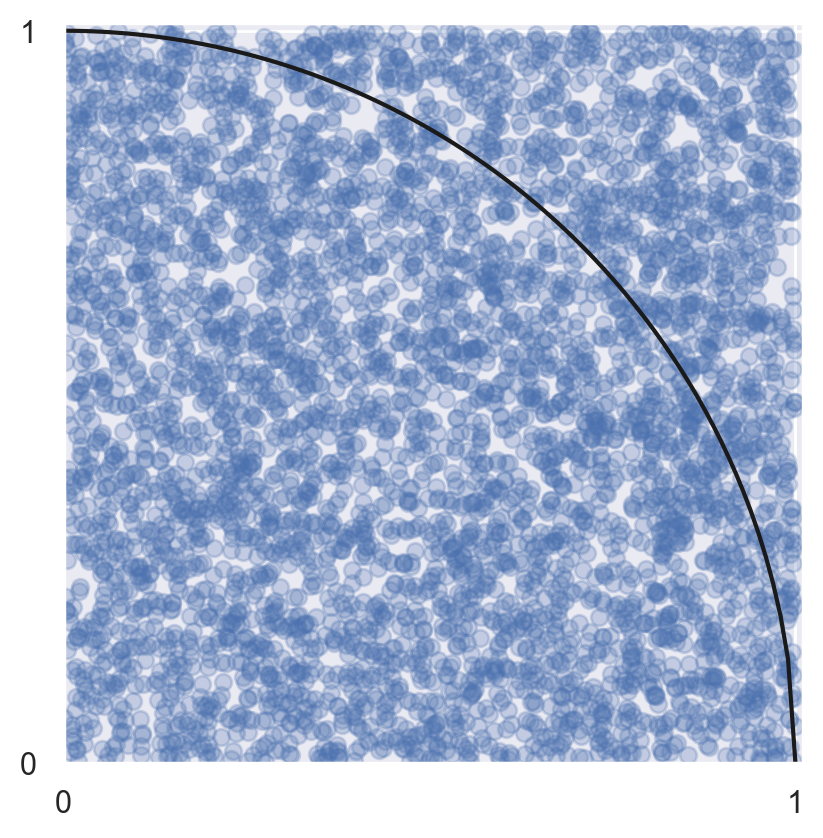

In [10]:
ax = make_axes()

xs = np.linspace(0, 1, 100)
ax.plot(xs, quarter_circle(xs), c="k");

ax.scatter(x, y,  alpha=0.25);

Finally, we highlight those samples that lie inside the unit circle, $x^2 + y^2 \leq 1$.

In [11]:
in_cirle = x**2 + y**2 <= 1

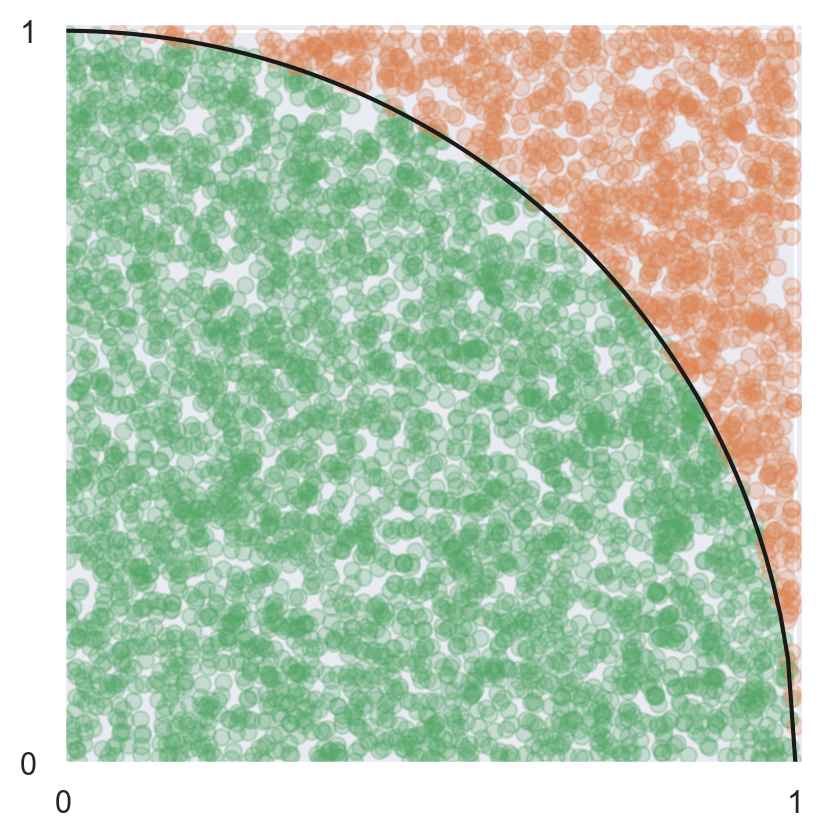

In [12]:
ax = make_axes()

xs = np.linspace(0, 1, 100)
ax.plot(xs, quarter_circle(xs), c="k");

ax.scatter(x[in_cirle], y[in_cirle], c="C2", alpha=0.25);
ax.scatter(x[~in_cirle], y[~in_cirle], c="C1", alpha=0.25);

A Monte Carlo approximation for $\pi$ arises from considering the proportion of samples that lie within the unit circle.  This proportion is the ratio of the area of the quarter unit circle, $\frac{\pi}{4}$, to the area of the square, 1.  Therefore we expect $\frac{\pi}{4}$ of the samples to be within the unit circle.

Calculating this quantity and multiplying by four, we have a reasonable, if crude, approximation of $\pi$.

In [13]:
4 * in_cirle.mean()

3.12

## Overthinking It

The application of Monte Carlo methods to multi-armed bandits to be discussed in future posts arises when we examine closely why this intuitive approximation works.

Let

$$Q = \{(x, y) \in \mathbb{R}^2\ |\ 0 \leq x, y \leq 1,\ x^2 + y^2 \leq 1\}$$

be the quarter of the unit circle in the first quadrant, and let $\mathbb{1}_Q$ be the [indicator function](https://en.wikipedia.org/wiki/Indicator_function) of $Q$,

$$\mathbb{1}_Q((x, y)) = \begin{cases}
    1 & \textrm{if } 0 \leq x, y \leq 1,\ x^2 + y^1 \leq 1 \\
    0 & \textrm{otherwise}
\end{cases}.$$

A basic [result](https://en.wikipedia.org/wiki/Indicator_function#Mean,_variance_and_covariance) of probability theory is that the expected value of an indicator function is the probability of its associated set, so

$$\mathbb{E}(\mathbb{1}_Q) = \mathbb{P}(Q) = \mathbb{P}(0 \leq x, y \leq 1,\ x^2 + y^2 \leq 1) = \frac{\pi}{4}.$$

**The fact that $\mathbb{1}_Q$ is an [unbiased estimator](https://en.wikipedia.org/wiki/Bias_of_an_estimator) of $\mathbb{P}(Q)$ will enable an efficient implementation of [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling) in the upcoming post series on multi-armed bandits.**

### The Law of Large Numbers

To understand exactly why this approximation works, we turn to the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers).
If we denote our random samples as $(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)$, the law of large shows that

$$\hat{\pi}_n = \frac{4}{n} \sum_{i = 1}^n \mathbb{1}_Q((x_i, y_i)) \to 4 \cdot \mathbb{E}(\mathbb{1}_Q) = \pi$$

as $n \to \infty$.

We visualize this convergence below.

In [14]:
n = 1 + np.arange(N)
π_hat = 4 * in_cirle.cumsum() / n

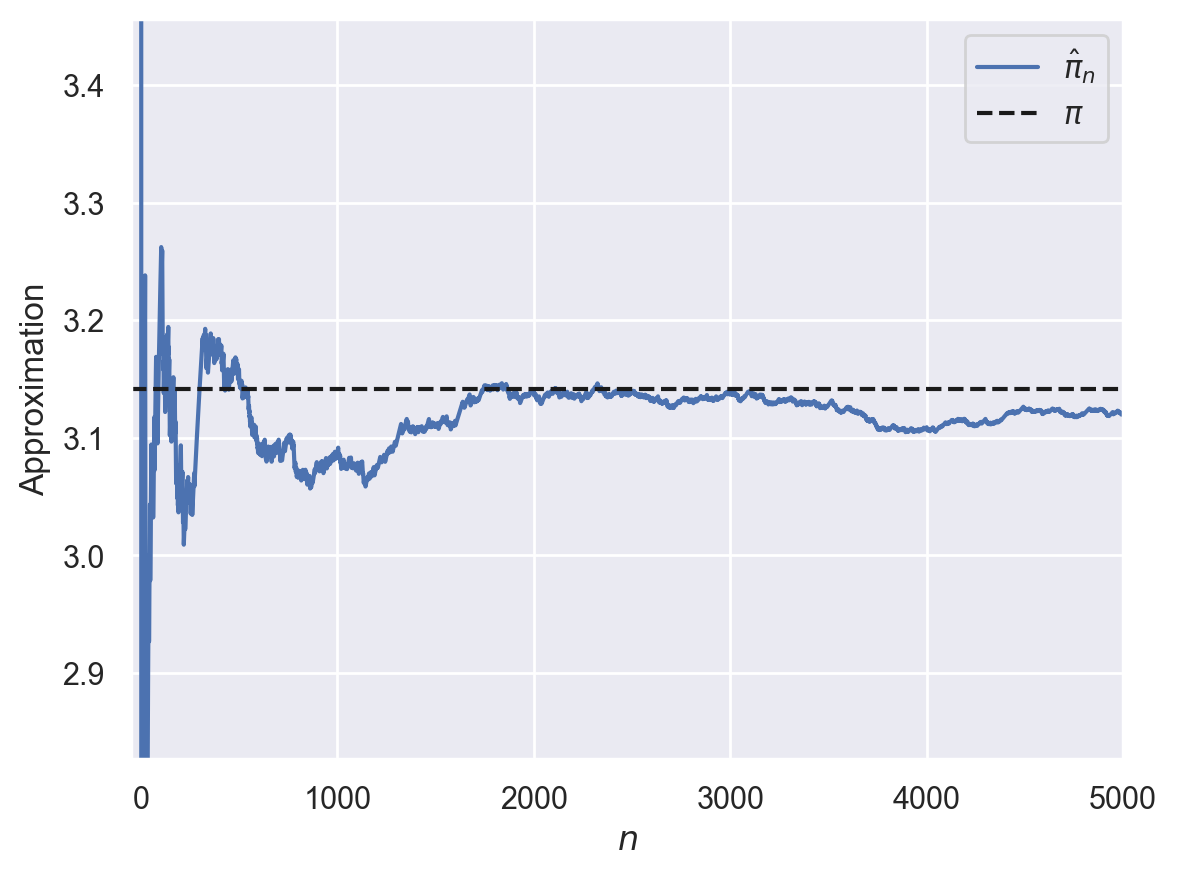

In [15]:
fig, ax  = plt.subplots()

ax.plot(n, π_hat, label=r"$\hat{\pi}_n$");
ax.axhline(np.pi, c="k", ls="--", label=r"$\pi$");

ax.set_xlim(-50, N);
ax.set_xlabel("$n$");

ax.set_ylim(0.9 * np.pi, 1.1 * np.pi);
ax.set_ylabel("Approximation");

ax.legend();

Note that while $\hat{\pi}_n$ generally improves as an estimator as $n$ increases, it tends to wander a bit.

### The Central Limit Theorem

While the large law of numbers guarantees that our Monte Carlo approximation will converge to the value of $\pi$ given enough samples, it is natural to ask how far we expect our approximation to deviate from the true value for any finite sample size.  The [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) answers this question.  Before invoking this theorem, we calculate the variance of $\mathbb{1}_Q$.  Since $0^2 = 0$ and $1^2 = 1$, $(\mathbb{1}_Q)^2 = \mathbb{1}_Q$, and we see that

$$\begin{align}
    \mathbb{Var}(\mathbb{1}_Q)
        & = \mathbb{E}\left((\mathbb{1}_Q)^2\right) - \left(\mathbb{E}(\mathbb{1}_Q)\right)^2 \\
        & = \mathbb{E}(\mathbb{1}_Q) - \frac{\pi^2}{16} \\
        & = \frac{\pi}{4} - \frac{\pi^2}{16} \\
        & = \frac{\pi}{4} \cdot \left(1 - \frac{\pi}{4}\right).
\end{align}$$

So $\mathbb{Var}(4 \cdot \mathbb{1}_Q) =\pi \cdot (4 - \pi),$ and by the central limit theorem

$$\sqrt{n}\left(\hat{\pi}_n - \pi\right) \overset{d}{\to} N\left(0, \pi \cdot (4 - \pi)\right).$$

By the definition of [convergence in distribution](https://en.wikipedia.org/wiki/Convergence_of_random_variables#Convergence_in_distribution),

$$\mathbb{P}\left(\sqrt{n}\left(\hat{\pi}_n - \pi\right) \leq z \right) \to \Phi\left(\frac{z}{\sqrt{\pi 
\cdot (4 - \pi)}}\right),$$

where $\Phi$ is the cumulative distribution function of the standard normal distribution.  By the symmetry of the this distribution,

$$\mathbb{P}\left(\sqrt{n}\left|\hat{\pi}_n - \pi\right| \leq z \right) \to 2 \cdot \Phi\left(\frac{z}{\sqrt{\pi 
\cdot (4 - \pi)}}\right) - 1.$$

Therefore an asymptotic confidence interval with coverage $1 - \alpha$ for $\left|\hat{\pi}_n - \pi\right|$ has width

$$\sqrt{\frac{\pi \cdot (4 - \pi)}{n}} \cdot \Phi^{-1}\left(1 - \frac{\alpha}{2}\right).$$ 

We now add an asymptotic 95% confidence interval to our previous plot.

In [16]:
ALPHA = 0.05

ci_width = np.sqrt(np.pi * (4 - np.pi) / n) * norm.ppf(1 - ALPHA / 2)

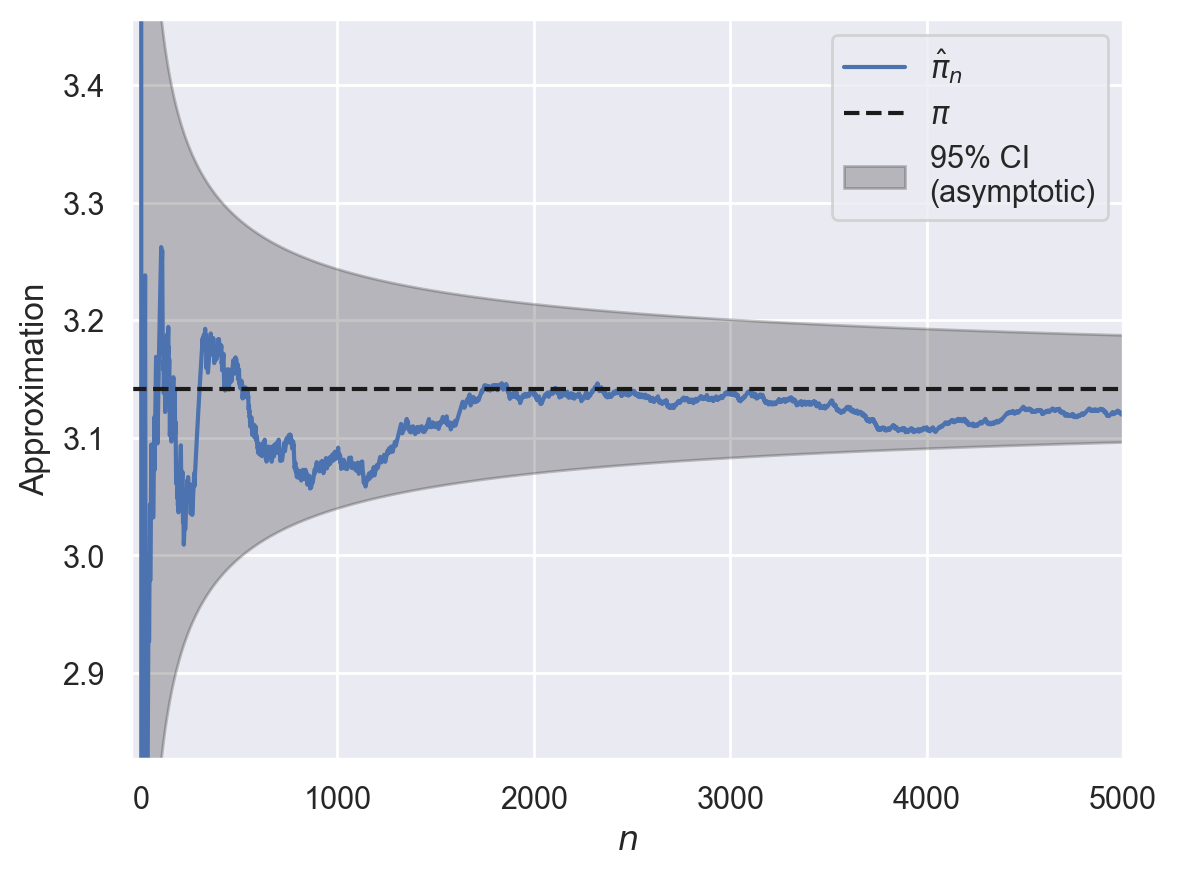

In [17]:
fig, ax  = plt.subplots()

ax.plot(n, π_hat, label=r"$\hat{\pi}_n$");

ax.axhline(np.pi, c="k", ls="--", label=r"$\pi$");
ax.fill_between(
    n, np.pi - ci_width, np.pi + ci_width,
    color="k", alpha=0.25,
    label=f"{1 - ALPHA:.0%} CI\n(asymptotic)"
);

ax.set_xlim(-50, N);
ax.set_xlabel("$n$");

ax.set_ylim(0.9 * np.pi, 1.1 * np.pi);
ax.set_ylabel("Approximation");

ax.legend();

We see that the approximation remains within this asymptotic confidence interval.

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/f16d29df99287f204b57ae460cfb27ce).

In [18]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Tue Feb 11 2025

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.29.0

numpy     : 1.26.4
seaborn   : 0.13.2
matplotlib: 3.9.2

